### Imports

In [1]:
import pathlib
import os
import pickle
import string

import pandas as pd
import numpy as np

#### Remark on data

\<v>place_with_error<\v> highlights the specific segment of the sentence which contains an error

there can be multiple rows with the same seg_id in the table but this error-highlighted segments will be different

In [4]:
data_folder = '../data/wmt21'
mqm_annotation_path = os.path.join(data_folder, 'mqm_scores', 'mqm-newstest2021_ende.tsv')
mqm_avg_scores_path = os.path.join(data_folder, 'mqm_scores', 'mqm-newstest2021_ende.avg_seg_scores.tsv')

news_refC_path = os.path.join(data_folder, 'reference', 'newstest2021.en-de.ref.ref-C.de')
news_refD_path = os.path.join(data_folder, 'reference', 'newstest2021.en-de.ref.ref-D.de')

# mqm_annotation_df = pd.read_csv(mqm_annotation_path, sep='\t', on_bad_lines='warn')

### Read and analyse mqm average scores

In [5]:
mqm_scores_df = pd.read_csv(mqm_avg_scores_path, sep=' |\t', engine='python')
mqm_scores_df

,system,mqm_avg_score,seg_id
0,Facebook-AI,-5.000000,1
1,Facebook-AI,-5.000000,2
2,Facebook-AI,-0.000000,3
3,Facebook-AI,-0.000000,4
4,Facebook-AI,-5.000000,5
...,...,...,...
17029,ref-D,-0.000000,998
17030,ref-D,-0.000000,999
17031,ref-D,-0.000000,1000
17032,ref-D,-0.000000,1001


In [4]:
mqm_scores_df.groupby('mqm_avg_score').seg_id.count()

mqm_avg_score
-0.000000     5261
-0.100000       93
-0.200000       15
-0.300000        2
-0.400000        1
-0.500000        1
-1.000000     1544
-1.100000       77
-1.200000       13
-10.000000     213
-10.100000       3
-11.000000      51
-11.100000       4
-11.200000       2
-12.000000      10
-12.100000       2
-13.000000       2
-15.000000      66
-15.100000       3
-16.000000       8
-16.100000       1
-17.000000       2
-2.000000      317
-2.100000       22
-2.200000        2
-2.300000        4
-20.000000      25
-20.100000       1
-21.000000       6
-25.000000      14
-3.000000       79
-3.100000        6
-3.200000        1
-4.000000       19
-4.100000        1
-5.000000      815
-5.100000       13
-5.200000        1
-6.000000      199
-6.100000       10
-6.200000        3
-7.000000       32
-7.100000        1
-7.200000        1
-8.000000        7
-8.100000        3
-9.000000        3
None          8075
Name: seg_id, dtype: int64

In [5]:
def f(x):
    if x == 'None':
        return None
    else:
        return float(x)
mqm_scores_df['mqm_avg_score'] = mqm_scores_df['mqm_avg_score'].apply(lambda x: f(x))

In [6]:
mqm_scores_df['seg_id'] = mqm_scores_df['seg_id'].apply(lambda x: int(x))

<AxesSubplot:ylabel='Density'>

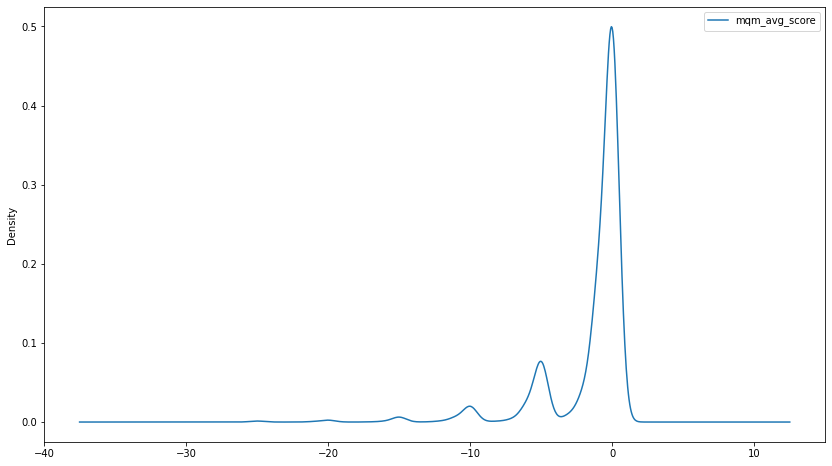

In [7]:
mqm_scores_df[['mqm_avg_score']].plot.kde(figsize=(14, 8))

In [8]:
mqm_scores_df.mqm_avg_score.describe()

count    8959.000000
mean       -1.520739
std         3.083910
min       -25.000000
25%        -1.000000
50%         0.000000
75%        -0.000000
max        -0.000000
Name: mqm_avg_score, dtype: float64

In [58]:
mqm_scores_df[mqm_scores_df.mqm_avg_score.isna()]

,system,mqm_avg_score,seg_id
51,Facebook-AI,NaN,52
52,Facebook-AI,NaN,53
53,Facebook-AI,NaN,54
54,Facebook-AI,NaN,55
55,Facebook-AI,NaN,56
...,...,...,...
16996,ref-D,NaN,965
16997,ref-D,NaN,966
16998,ref-D,NaN,967
16999,ref-D,NaN,968


In [8]:
human_refs = ['ref.A', 'ref.B', 'ref.C', 'ref.D']

In [9]:
human_refs2 = ['ref-A', 'ref-B', 'ref-C', 'ref-D']

### Get and process MQM categorical errors 

In [4]:
with open(mqm_annotation_path, 'r') as f:
    mqm_annotations_all = f.readlines()

In [5]:
mqm_columns = mqm_annotations_all[0][:-1].split('\t')
mqm_annotation_df = pd.DataFrame(columns=mqm_columns)

for i, s in enumerate(mqm_annotations_all[1:]):
    fields = s[:-1].split('\t')
    if len(fields) != 10:
        break
    new_row = {mqm_columns[i]: fields[i] for i in range(10)}
    mqm_annotation_df = mqm_annotation_df.append(new_row, ignore_index=True)
mqm_annotation_df['seg_id'] = mqm_annotation_df['seg_id'].apply(lambda x: int(x))

In [16]:
error_categories = mqm_annotation_df.category.unique()
error_categories

array(['No-error', 'Style/Awkward', 'Other', 'Accuracy/Mistranslation',
       'Fluency/Punctuation', 'Accuracy/Omission',
       'Accuracy/Untranslated', 'Terminology/Inappropriate',
       'Fluency/Grammar', 'Fluency/Inconsistency', 'Fluency/Spelling',
       'Source_error', 'Accuracy/Addition', 'Fluency/Register',
       'Terminology/Inconsistent', 'Fluency/Display',
       'Locale_convention/Currency', 'Locale_convention/Date',
       'Locale_convention/Time'], dtype=object)

In [6]:
# Get reference C
ref_c_df = mqm_annotation_df[mqm_annotation_df.system == 'ref.C']
ref_c_df.reset_index(inplace=True, drop=True)

In [7]:
# Get reference D
ref_d_df = mqm_annotation_df[mqm_annotation_df.system == 'ref.D']
ref_d_df.reset_index(inplace=True, drop=True)

In [10]:
# Get MT system output
mt_output_df = mqm_annotation_df[~mqm_annotation_df.system.isin(human_refs)]
mt_output_df

,system,doc,doc_id,seg_id,rater,source,target,category,severity,comment
0,hyp.Facebook-AI,abcnews.420140,1,715,rater2,UN says thousands of anti-Pakistan militants i...,UN: Tausende militante Anti-Pakistan-Kämpfer i...,No-error,No-error,
1,hyp.HuaweiTSC,abcnews.420140,1,715,rater6,UN says thousands of anti-Pakistan militants i...,"UN sagt, Tausende von Anti-Pakistan-Kämpfern i...",No-error,No-error,
2,hyp.Nemo,abcnews.420140,1,715,rater7,UN says thousands of anti-Pakistan militants i...,"<v>UN sagt,</v> Tausende von Anti-Pakistan-Käm...",Style/Awkward,Major,
3,hyp.Nemo,abcnews.420140,1,715,rater7,UN says thousands of anti-Pakistan militants i...,"UN sagt, Tausende von <v>Anti-Pakistan-Kämpfer...",Style/Awkward,Major,
4,hyp.Online-W,abcnews.420140,1,715,rater9,UN says thousands of anti-Pakistan militants i...,<v>UN sagt Tausende anti-pakistanische Kämpfer...,Style/Awkward,Minor,
...,...,...,...,...,...,...,...,...,...,...
10726,hyp.metricsystem2,voa-en.100681,11,780,rater2,The tit-for-tat closures further escalated the...,Die vorläufigen Schließungen haben die Spannun...,No-error,No-error,
10727,hyp.metricsystem3,voa-en.100681,11,780,rater4,The tit-for-tat closures further escalated the...,Die vorläufigen Schließungen verschärften die ...,No-error,No-error,
10728,hyp.metricsystem4,voa-en.100681,11,780,rater1,The tit-for-tat closures further escalated the...,<v>Die tit-for-tat-Schließungen</v> eskalierte...,Terminology/Inappropriate,Major,
10729,hyp.metricsystem4,voa-en.100681,11,780,rater1,The tit-for-tat closures further escalated the...,Die tit-for-tat-Schließungen <v>eskalierten di...,Style/Awkward,Minor,


---

### Analysis of error severity distribution for rater2 and rater7. 

<AxesSubplot:>

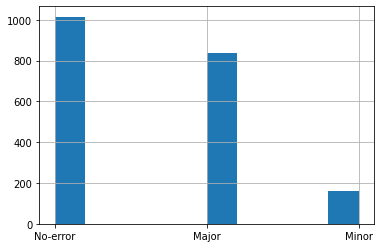

In [19]:
mt_output_df[mt_output_df.rater=='rater2'].severity.hist()

<AxesSubplot:>

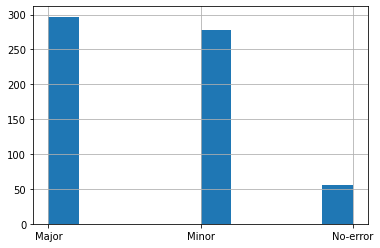

In [20]:
mt_output_df[mt_output_df.rater=='rater7'].severity.hist()

In [21]:
r7_ids = mt_output_df[mt_output_df.rater=='rater7'].seg_id.unique()

In [22]:
r2_ids = mt_output_df[mt_output_df.rater=='rater2'].seg_id.unique()

In [23]:
mqm_annotation_df[mqm_annotation_df["system"]=="hyp.Facebook-AI"]

,system,doc,doc_id,seg_id,rater,source,target,category,severity,comment
0,hyp.Facebook-AI,abcnews.420140,1,715,rater2,UN says thousands of anti-Pakistan militants i...,UN: Tausende militante Anti-Pakistan-Kämpfer i...,No-error,No-error,
18,hyp.Facebook-AI,abcnews.420140,2,716,rater2,ISLAMABAD -- A UN report says more than 6000 P...,ISLAMABAD – Einem UN-Bericht zufolge verstecke...,Fluency/Punctuation,Major,
43,hyp.Facebook-AI,abcnews.420140,3,717,rater2,"The report released this week said the group, ...",In dem in dieser Woche veröffentlichten Berich...,No-error,No-error,
61,hyp.Facebook-AI,abcnews.420140,4,718,rater2,Some of TTP's members have even joined the IS ...,Einige Mitglieder der TTP haben sich sogar dem...,No-error,No-error,
80,hyp.Facebook-AI,abcnews.420140,5,719,rater2,The Afghan government did not respond Sunday t...,Die afghanische Regierung reagierte am Sonntag...,No-error,No-error,
...,...,...,...,...,...,...,...,...,...,...
10650,hyp.Facebook-AI,voa-en.100681,8,777,rater6,Washington ordered China to close the Houston ...,"Washington befahl China, das Büro in Houston z...",No-error,No-error,
10675,hyp.Facebook-AI,voa-en.100681,9,778,rater6,As Chinese consulate closure in Houston took e...,Als die Schließung des chinesischen Konsulats ...,No-error,No-error,
10695,hyp.Facebook-AI,voa-en.100681,10,779,rater6,Wang said on Saturday that violated internatio...,"Wang sagte am Samstag, dass dies gegen interna...",No-error,No-error,
10714,hyp.Facebook-AI,voa-en.100681,11,780,rater6,The tit-for-tat closures further escalated the...,Die <v>gegenseitigen</v> Schließungen haben di...,Style/Awkward,Minor,


In [24]:
id_intersect = set(r7_ids).intersection(set(r2_ids))
len(id_intersect)

260

In [25]:
test_subset_df = mt_output_df[mt_output_df.seg_id.isin(id_intersect)][mt_output_df.rater.isin(['rater2',
                                                                                                'rater7'])]
test_subset_df

/home/ira/anaconda3/envs/eval_metrics/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,system,doc,doc_id,seg_id,rater,source,target,category,severity,comment
0,hyp.Facebook-AI,abcnews.420140,1,715,rater2,UN says thousands of anti-Pakistan militants i...,UN: Tausende militante Anti-Pakistan-Kämpfer i...,No-error,No-error,
2,hyp.Nemo,abcnews.420140,1,715,rater7,UN says thousands of anti-Pakistan militants i...,"<v>UN sagt,</v> Tausende von Anti-Pakistan-Käm...",Style/Awkward,Major,
3,hyp.Nemo,abcnews.420140,1,715,rater7,UN says thousands of anti-Pakistan militants i...,"UN sagt, Tausende von <v>Anti-Pakistan-Kämpfer...",Style/Awkward,Major,
5,hyp.UEdin,abcnews.420140,1,715,rater2,UN says thousands of anti-Pakistan militants i...,"<v>UNO sagt, dass Tausende von Anti-Pakistan-K...",Style/Awkward,Major,
11,hyp.metricsystem3,abcnews.420140,1,715,rater2,UN says thousands of anti-Pakistan militants i...,"UN sagt, Tausende von Anti-Pakistan-Aktivisten...",No-error,No-error,
...,...,...,...,...,...,...,...,...,...,...
10424,hyp.VolcTrans-AT,upi.228777,7,509,rater7,It has not issued any advisement against eatin...,Sie hat weder eine Beratung <v>gegen den Verze...,Style/Awkward,Major,
10425,hyp.VolcTrans-AT,upi.228777,7,509,rater7,It has not issued any advisement against eatin...,Sie hat weder eine Beratung gegen den Verzehr ...,Accuracy/Mistranslation,Major,
10426,hyp.VolcTrans-GLAT,upi.228777,7,509,rater2,It has not issued any advisement against eatin...,Sie hat weder eine Empfehlung zum Verzehr best...,No-error,No-error,
10427,hyp.eTranslation,upi.228777,7,509,rater2,It has not issued any advisement against eatin...,"Sie hat weder eine Empfehlung herausgegeben, b...",No-error,No-error,


In [26]:
test_subset_df["sys_seg"] = test_subset_df[["system","seg_id"]].apply(tuple, axis=1)

In [27]:
test_subset_r2_df = test_subset_df[test_subset_df.rater == 'rater2']
test_subset_r7_df = test_subset_df[test_subset_df.rater == 'rater7']

In [28]:
test_subset_r2_df.groupby("system").count()

,doc,doc_id,seg_id,rater,source,target,category,severity,comment,sys_seg
system,,,,,,,,,,
hyp.Facebook-AI,55,55,55,55,55,55,55,55,55,55
hyp.HuaweiTSC,78,78,78,78,78,78,78,78,78,78
hyp.Nemo,59,59,59,59,59,59,59,59,59,59
hyp.Online-W,83,83,83,83,83,83,83,83,83,83
hyp.UEdin,75,75,75,75,75,75,75,75,75,75
hyp.VolcTrans-AT,94,94,94,94,94,94,94,94,94,94
hyp.VolcTrans-GLAT,83,83,83,83,83,83,83,83,83,83
hyp.eTranslation,35,35,35,35,35,35,35,35,35,35
hyp.metricsystem1,39,39,39,39,39,39,39,39,39,39


In [29]:
test_subset_r7_df.groupby("system").count()

,doc,doc_id,seg_id,rater,source,target,category,severity,comment,sys_seg
system,,,,,,,,,,
hyp.Facebook-AI,76,76,76,76,76,76,76,76,76,76
hyp.HuaweiTSC,31,31,31,31,31,31,31,31,31,31
hyp.Nemo,17,17,17,17,17,17,17,17,17,17
hyp.UEdin,30,30,30,30,30,30,30,30,30,30
hyp.VolcTrans-AT,71,71,71,71,71,71,71,71,71,71
hyp.VolcTrans-GLAT,7,7,7,7,7,7,7,7,7,7
hyp.eTranslation,63,63,63,63,63,63,63,63,63,63
hyp.metricsystem1,92,92,92,92,92,92,92,92,92,92
hyp.metricsystem2,62,62,62,62,62,62,62,62,62,62


### Example of human rating inconsistency across raters

In [32]:
example_seg_id = 715
mt_output_df[mt_output_df.seg_id==example_seg_id].sort_values(['system','rater'])[['system', 'rater', 'target', 'category', 'severity']]

,system,rater,target,category,severity
0,hyp.Facebook-AI,rater2,UN: Tausende militante Anti-Pakistan-Kämpfer i...,No-error,No-error
1,hyp.HuaweiTSC,rater6,"UN sagt, Tausende von Anti-Pakistan-Kämpfern i...",No-error,No-error
2,hyp.Nemo,rater7,"<v>UN sagt,</v> Tausende von Anti-Pakistan-Käm...",Style/Awkward,Major
3,hyp.Nemo,rater7,"UN sagt, Tausende von <v>Anti-Pakistan-Kämpfer...",Style/Awkward,Major
4,hyp.Online-W,rater9,<v>UN sagt Tausende anti-pakistanische Kämpfer...,Style/Awkward,Minor
5,hyp.UEdin,rater2,"<v>UNO sagt, dass Tausende von Anti-Pakistan-K...",Style/Awkward,Major
6,hyp.VolcTrans-AT,rater10,"<v>UN sagt, dass Tausende von anti-pakistanisc...",Other,Major
7,hyp.VolcTrans-GLAT,rater1,"UN sagt, dass Tausende von anti-pakistanischen...",No-error,No-error
8,hyp.eTranslation,rater12,<v>UN sagt Tausenden von Anti-Pakistan-Kämpfer...,Accuracy/Mistranslation,Major
9,hyp.metricsystem1,rater13,<v>UNO sagt Tausende Anti-Pakistan-Kämpfer in ...,Style/Awkward,Major


In [33]:
mt_output_df[mt_output_df.seg_id==example_seg_id].sort_values(['system','rater']).target.values[ 2 ]

'<v>UN sagt,</v> Tausende von Anti-Pakistan-Kämpfern in Afghanistan'

In [34]:
mt_output_df[mt_output_df.seg_id==example_seg_id].sort_values(['system','rater']).target.values[ 3 ]

'UN sagt, Tausende von <v>Anti-Pakistan-Kämpfern</v> in Afghanistan'

In [35]:
mt_output_df[mt_output_df.seg_id==example_seg_id].sort_values(['system','rater']).target.values[ 10 ]

'Laut UN sind Tausende von Anti-Pakistan-Kämpfern in Afghanistan'

In [36]:
mt_output_df[mt_output_df.seg_id==example_seg_id].sort_values(['system','rater']).target.values[ 11 ]

'UN sagt, Tausende von Anti-Pakistan-Aktivisten in Afghanistan'

In [37]:
mt_output_df[mt_output_df.seg_id==example_seg_id].sort_values(['system','rater']).target.values

array(['UN: Tausende militante Anti-Pakistan-Kämpfer in Afghanistan',
       'UN sagt, Tausende von Anti-Pakistan-Kämpfern in Afghanistan',
       '<v>UN sagt,</v> Tausende von Anti-Pakistan-Kämpfern in Afghanistan',
       'UN sagt, Tausende von <v>Anti-Pakistan-Kämpfern</v> in Afghanistan',
       '<v>UN sagt Tausende anti-pakistanische Kämpfer in Afghanistan</v>',
       '<v>UNO sagt, dass Tausende von Anti-Pakistan-Kämpfern in Afghanistan</v>',
       '<v>UN sagt, dass Tausende von anti-pakistanischen Militanten in Afghanistan</v>',
       'UN sagt, dass Tausende von anti-pakistanischen Kämpfern in Afghanistan',
       '<v>UN sagt Tausenden von Anti-Pakistan-Kämpfern in Afghanistan</v>',
       '<v>UNO sagt Tausende Anti-Pakistan-Kämpfer in Afghanistan</v>',
       'Laut UN sind Tausende von Anti-Pakistan-Kämpfern in Afghanistan',
       'UN sagt, Tausende von Anti-Pakistan-Aktivisten in Afghanistan',
       'UNO: Tausende Anti-Pakistan-Kämpfer in Afghanistan',
       'UN sagt, Tau

--- 
### Join average segment errors and error categories

In [11]:
mt_mqm_scores_df = mqm_scores_df[~mqm_scores_df.system.isin(human_refs2)]
mt_mqm_scores_df

,system,mqm_avg_score,seg_id
0,Facebook-AI,-5.000000,1
1,Facebook-AI,-5.000000,2
2,Facebook-AI,-0.000000,3
3,Facebook-AI,-0.000000,4
4,Facebook-AI,-5.000000,5
...,...,...,...
13021,metricsystem5,-10.000000,998
13022,metricsystem5,-5.000000,999
13023,metricsystem5,-10.000000,1000
13024,metricsystem5,-10.000000,1001


In [12]:
mt_output_df['system_name'] = mt_output_df.system.apply(lambda x: x.split('.')[1])
mt_output_df

/home/ira/anaconda3/envs/eval_metrics/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,system,doc,doc_id,seg_id,rater,source,target,category,severity,comment,system_name
0,hyp.Facebook-AI,abcnews.420140,1,715,rater2,UN says thousands of anti-Pakistan militants i...,UN: Tausende militante Anti-Pakistan-Kämpfer i...,No-error,No-error,,Facebook-AI
1,hyp.HuaweiTSC,abcnews.420140,1,715,rater6,UN says thousands of anti-Pakistan militants i...,"UN sagt, Tausende von Anti-Pakistan-Kämpfern i...",No-error,No-error,,HuaweiTSC
2,hyp.Nemo,abcnews.420140,1,715,rater7,UN says thousands of anti-Pakistan militants i...,"<v>UN sagt,</v> Tausende von Anti-Pakistan-Käm...",Style/Awkward,Major,,Nemo
3,hyp.Nemo,abcnews.420140,1,715,rater7,UN says thousands of anti-Pakistan militants i...,"UN sagt, Tausende von <v>Anti-Pakistan-Kämpfer...",Style/Awkward,Major,,Nemo
4,hyp.Online-W,abcnews.420140,1,715,rater9,UN says thousands of anti-Pakistan militants i...,<v>UN sagt Tausende anti-pakistanische Kämpfer...,Style/Awkward,Minor,,Online-W
...,...,...,...,...,...,...,...,...,...,...,...
10726,hyp.metricsystem2,voa-en.100681,11,780,rater2,The tit-for-tat closures further escalated the...,Die vorläufigen Schließungen haben die Spannun...,No-error,No-error,,metricsystem2
10727,hyp.metricsystem3,voa-en.100681,11,780,rater4,The tit-for-tat closures further escalated the...,Die vorläufigen Schließungen verschärften die ...,No-error,No-error,,metricsystem3
10728,hyp.metricsystem4,voa-en.100681,11,780,rater1,The tit-for-tat closures further escalated the...,<v>Die tit-for-tat-Schließungen</v> eskalierte...,Terminology/Inappropriate,Major,,metricsystem4
10729,hyp.metricsystem4,voa-en.100681,11,780,rater1,The tit-for-tat closures further escalated the...,Die tit-for-tat-Schließungen <v>eskalierten di...,Style/Awkward,Minor,,metricsystem4


In [13]:
joined_mqm_errors_df = mt_mqm_scores_df.merge(mt_output_df, 
                                left_on=['system','seg_id'], 
                                right_on = ['system_name','seg_id'], 
                                how='left')

In [14]:
joined_mqm_errors_df = joined_mqm_errors_df[~joined_mqm_errors_df['target'].isna()]
joined_mqm_errors_df.reset_index(inplace=True, drop=True)
joined_mqm_errors_df = joined_mqm_errors_df[['system_name', 'seg_id', 'doc', 
                                             'source', 'target', 'rater', 'mqm_avg_score', 'category', 
                                             'severity', 'comment']]
joined_mqm_errors_df

,system_name,seg_id,doc,source,target,rater,mqm_avg_score,category,severity,comment
0,Facebook-AI,1,rt.com.131279,Couple MACED at California dog park for not we...,"Paar <v>MACED</v> im kalifornischen Hundepark,...",rater2,-5.000000,Accuracy/Mistranslation,Major,
1,Facebook-AI,2,rt.com.131279,There's mask-shaming and then there's full on ...,Es gibt Mask-Shaming und dann gibt es <v>voll ...,rater2,-5.000000,Style/Awkward,Major,
2,Facebook-AI,3,rt.com.131279,A California couple having lunch with their pu...,"Ein kalifornisches Paar, das mit seinem Welpen...",rater2,-0.000000,No-error,No-error,
3,Facebook-AI,4,rt.com.131279,Ash O'Brien and husband Jarett Kelley say they...,"Ash O'Brien und Ehemann Jarett Kelley sagen, d...",rater2,-0.000000,No-error,No-error,
4,Facebook-AI,5,rt.com.131279,"The pair had their masks off to eat, when a ""r...","Die beiden hatten ihre Masken abgenommen, um z...",rater2,-5.000000,Style/Awkward,Major,
...,...,...,...,...,...,...,...,...,...,...
8345,metricsystem5,1000,sky.com.33889,"John Mann, the government's independent advise...","<v>John Mann, der unabhängige Berater der Regi...",rater13,-10.000000,Accuracy/Mistranslation,Major,
8346,metricsystem5,1000,sky.com.33889,"John Mann, the government's independent advise...","<v>John Mann, der unabhängige Berater der Regi...",rater13,-10.000000,Fluency/Punctuation,Major,
8347,metricsystem5,1001,sky.com.33889,"Meanwhile, the Campaign Against Antisemitism a...",<v>Unterdessen forderte die Kampagne gegen Ant...,rater13,-10.000000,Accuracy/Mistranslation,Major,
8348,metricsystem5,1001,sky.com.33889,"Meanwhile, the Campaign Against Antisemitism a...",<v>Unterdessen forderte die Kampagne gegen Ant...,rater13,-10.000000,Fluency/Punctuation,Major,


In [15]:
joined_mqm_errors_df.seg_id.nunique()

527

### Prepare reference C and join with mt_dataset

In [16]:
def delete_tags(row): 
    return row.replace('<v>', '').replace('</v>', '')

In [44]:
prep_ref = ref_c_df.drop_duplicates(subset=['seg_id', 'doc_id'], keep='last')[['seg_id', 'target']].copy()
prep_ref['target'] = prep_ref['target'].apply(lambda x: delete_tags(x))
prep_ref.reset_index(drop=True, inplace=True)
prep_ref = prep_ref.rename(columns={'target': 'reference'})
prep_ref

,seg_id,reference
0,61,Virginia Beach demontiert Konföderierten-Denkmal
1,62,"VIRGINIA BEACH, VA. -- Die Stadt Virginia Beac..."
2,63,"Wie Medien berichteten, bauten Arbeiter das 8,..."
3,64,Das Denkmal wurde 1905 vor dem alten Gerichtsg...
4,65,Der Stadtrat stimmte am Donnerstagabend einsti...
...,...,...
997,776,"Die Anordnung Chinas, das Konsulat in Chengdu ..."
998,777,"Washington forderte China auf, das Büro in Hou..."
999,778,Als die Schließung des chinesischen Konsulats ...
1000,779,"Wang sagte am Samstag, dies verstoße gegen int..."


In [45]:
full_df = joined_mqm_errors_df.merge(prep_ref, left_on=['seg_id'], right_on = ['seg_id'], how='inner')
full_df

,system_name,seg_id,doc,source,target,rater,mqm_avg_score,category,severity,comment,reference
0,Facebook-AI,1,rt.com.131279,Couple MACED at California dog park for not we...,"Paar <v>MACED</v> im kalifornischen Hundepark,...",rater2,-5.0,Accuracy/Mistranslation,Major,,Angriff mit Pfefferspray auf ein Paar in einem...
1,HuaweiTSC,1,rt.com.131279,Couple MACED at California dog park for not we...,"Paar <v>MACED</v> im kalifornischen Hundepark,...",rater4,-5.0,Accuracy/Untranslated,Major,,Angriff mit Pfefferspray auf ein Paar in einem...
2,Nemo,1,rt.com.131279,Couple MACED at California dog park for not we...,<v>Paar MACED im kalifornischen Hundepark für ...,rater4,-6.0,Style/Awkward,Minor,,Angriff mit Pfefferspray auf ein Paar in einem...
3,Nemo,1,rt.com.131279,Couple MACED at California dog park for not we...,Paar <v>MACED</v> im kalifornischen Hundepark ...,rater4,-6.0,Accuracy/Untranslated,Major,,Angriff mit Pfefferspray auf ein Paar in einem...
4,Online-W,1,rt.com.131279,Couple MACED at California dog park for not we...,Paar <v>MACED</v> in Kalifornien Hundepark für...,rater11,-5.0,Accuracy/Mistranslation,Major,,Angriff mit Pfefferspray auf ein Paar in einem...
...,...,...,...,...,...,...,...,...,...,...,...
8345,metricsystem1,1002,sky.com.33889,"Wiley, known as the Godfather of Grime and who...","Wiley, bekannt als Godfather of Grime und mit ...",rater9,-2.0,Style/Awkward,Minor,,"Wiley, bekannt als „Godfather of Grime“, desse..."
8346,metricsystem2,1002,sky.com.33889,"Wiley, known as the Godfather of Grime and who...","Wiley, bekannt als der <v>Pate des Schmutzes <...",rater13,-5.0,Style/Awkward,Major,,"Wiley, bekannt als „Godfather of Grime“, desse..."
8347,metricsystem3,1002,sky.com.33889,"Wiley, known as the Godfather of Grime and who...","Wiley, bekannt als Godfather of Grime und mit ...",rater11,-0.0,No-error,No-error,,"Wiley, bekannt als „Godfather of Grime“, desse..."
8348,metricsystem4,1002,sky.com.33889,"Wiley, known as the Godfather of Grime and who...","Wiley, bekannt als Godfather of Grime und mit ...",rater1,-0.0,No-error,No-error,,"Wiley, bekannt als „Godfather of Grime“, desse..."


In [71]:
full_df[full_df.duplicated(subset=['seg_id', 'system_name', 'category'])].sort_values(['system_name', 'seg_id'])

,system_name,seg_id,doc,source,target,rater,mqm_avg_score,category,severity,comment,reference
1203,Facebook-AI,107,guardian.306616,"Britain's Recovery Trial programme, which has ...","Das britische Recovery Trial-Programm, an dem ...",rater6,-2.0,Style/Awkward,Minor,,"Großbritanniens Recovery Trail-Programm, das a..."
1723,Facebook-AI,191,rte.en.ie.30771,"""You know, now it's different, 'cause kids are...","„Weißt du, jetzt ist es anders, weil die Kinde...",rater2,-15.0,Fluency/Punctuation,Major,,"„Wissen Sie, heute ist das anders, denn Kinder..."
1832,Facebook-AI,233,metro.co.uk.47971,"However, the pandemic means few clubs will be ...","Die Pandemie bedeutet jedoch, dass nur wenige ...",rater6,-3.0,Style/Awkward,Minor,,Doch aufgrund der Pandemie werden diesen Somme...
2390,Facebook-AI,298,bbc.500823,But Labour's shadow home secretary Nick Thomas...,Aber der Labour-Schatten-Innenminister Nick Th...,rater2,-7.0,Style/Awkward,Major,,"Nick Thomas-Symonds, der Schatten-Innenministe..."
2391,Facebook-AI,298,bbc.500823,But Labour's shadow home secretary Nick Thomas...,Aber der Labour-Schatten-Innenminister Nick Th...,rater2,-7.0,Style/Awkward,Minor,,"Nick Thomas-Symonds, der Schatten-Innenministe..."
...,...,...,...,...,...,...,...,...,...,...,...
7491,metricsystem5,924,brisbanetimes.com.au.275186,Unlike any of the other Five Eyes countries - ...,Im Gegensatz zu allen anderen Five Eyes-Länder...,rater2,-15.0,Fluency/Punctuation,Major,,Anders als die anderen Five-Eyes-Länder - die ...
7492,metricsystem5,924,brisbanetimes.com.au.275186,Unlike any of the other Five Eyes countries - ...,Im Gegensatz zu allen anderen Five Eyes-Länder...,rater2,-15.0,Fluency/Punctuation,Major,,Anders als die anderen Five-Eyes-Länder - die ...
7919,metricsystem5,974,independent.597197,"""It was disappointing, more the way we've ende...","<v>""</v>Es war enttäuschend, mehr die Art und ...",rater2,-10.0,Fluency/Punctuation,Major,,"„Es war enttäuschend, eher die Art und Weise, ..."
7964,metricsystem5,977,independent.597197,"""It's hard to take, but our main target was Eu...","<v>""</v>Es ist schwer zu ertragen, aber unser ...",rater2,-10.0,Fluency/Punctuation,Major,,"„Das ist schon eine harte Nummer, aber unser H..."


In [63]:
full_df.describe()

,seg_id,mqm_avg_score
count,8350.000000,8350.000000
mean,496.588383,-2.949808
std,298.755238,4.697664
min,1.000000,-25.000000
25%,276.000000,-5.000000
50%,529.000000,-1.000000
75%,742.000000,-0.000000
max,1002.000000,-0.000000


In [46]:
error_weights = {'No-error': 0, 'Minor': 1, 'Minor/Fluency/Punctuation': 0.1, 'Major': 5, 'Major/Non-translation': 25}

In [65]:
# full_df[(full_df['mqm_avg_score'].isna())]

In [79]:
full_df.to_csv('preprocessed_wmt21_news_data.tsv', index=False, sep='\t')